# Predicting maimai DX player map achievement scores

In [1]:
# pip install ipykernel ipympl jupyter matplotlib numpy pandas scikit-learn seaborn
# or: uv sync

In [2]:
import pandas as pd
from pathlib import Path

# Loading the data
maimai_path = Path("maimai.csv")
bpm_path = Path("bpm.csv")

maimai_df = pd.read_csv(maimai_path)
bpm_df = pd.read_csv(bpm_path)

dfs = [maimai_df, bpm_df]
for dataframe in dfs:
    print("="*40)
    print(dataframe.columns)
    print(dataframe.head(1))

Index(['Song', 'Genre', 'Version', 'Chart', 'Difficulty', 'Level', 'Achv',
       'Rank', 'FC/AP', 'Sync', 'DX ✦', 'DX %', 'Chart Constant', 'DX Score'],
      dtype='object')
    Song   Genre   Version Chart Difficulty Level    Achv Rank FC/AP  Sync  \
0  躯樹の墓守  maimai  UNiVERSE    DX      BASIC     6  94.23%  AAA    FC  SYNC   

   DX ✦    DX % Chart Constant DX Score  
0     0  75.40%              ?  570/756  
Index(['songId', 'bpm', 'releaseDate'], dtype='object')
      songId    bpm releaseDate
0  "411Ψ892"  184.0  2023-02-03


In [3]:
# Merging datasets
maimai_df.rename(columns={"Song": "songId"}, inplace=True)
merged_df = maimai_df.merge(bpm_df, on="songId", how="left")
print(f"Duplicated: {merged_df.duplicated().sum()}")
print(merged_df.head(3))

Duplicated: 0
            songId       Genre       Version Chart Difficulty Level    Achv  \
0            躯樹の墓守      maimai      UNiVERSE    DX      BASIC     6  94.23%   
1              系ぎて      maimai       BUDDiES    DX      BASIC     7  96.63%   
2  INTERNET YAMERO  POPS＆ANIME  BUDDiES PLUS    DX   ADVANCED    7+  96.34%   

  Rank FC/AP  Sync  DX ✦    DX % Chart Constant  DX Score    bpm releaseDate  
0  AAA    FC  SYNC     0  75.40%              ?   570/756  211.0  2022-02-10  
1  AAA     -  SYNC     0  74.20%              ?  766/1032   88.0  2024-02-29  
2  AAA     -  SYNC     0  73.20%            7.8  854/1167  185.0  2024-03-21  


In [4]:
# Clean up unnecessary columns
merged_df.drop(columns=["FC/AP", "Sync", "DX ✦", "DX %"], inplace=True)
print(merged_df.head(3))

# Expose missing values
merged_df["Chart Constant"] = pd.to_numeric(merged_df["Chart Constant"], errors='coerce')

            songId       Genre       Version Chart Difficulty Level    Achv  \
0            躯樹の墓守      maimai      UNiVERSE    DX      BASIC     6  94.23%   
1              系ぎて      maimai       BUDDiES    DX      BASIC     7  96.63%   
2  INTERNET YAMERO  POPS＆ANIME  BUDDiES PLUS    DX   ADVANCED    7+  96.34%   

  Rank Chart Constant  DX Score    bpm releaseDate  
0  AAA              ?   570/756  211.0  2022-02-10  
1  AAA              ?  766/1032   88.0  2024-02-29  
2  AAA            7.8  854/1167  185.0  2024-03-21  


In [5]:
# convert releaseDate to numerical values
merged_df['releaseDate'] = pd.to_datetime(merged_df['releaseDate'], errors='coerce')
merged_df['releaseDate'] = (merged_df['releaseDate'] - merged_df['releaseDate'].min()).dt.days
print(merged_df.head(3))

            songId       Genre       Version Chart Difficulty Level    Achv  \
0            躯樹の墓守      maimai      UNiVERSE    DX      BASIC     6  94.23%   
1              系ぎて      maimai       BUDDiES    DX      BASIC     7  96.63%   
2  INTERNET YAMERO  POPS＆ANIME  BUDDiES PLUS    DX   ADVANCED    7+  96.34%   

  Rank  Chart Constant  DX Score    bpm  releaseDate  
0  AAA             NaN   570/756  211.0       3501.0  
1  AAA             NaN  766/1032   88.0       4250.0  
2  AAA             7.8  854/1167  185.0       4271.0  


In [6]:
print("Rows with missing values:")
print(merged_df[merged_df.isna().any(axis=1)])
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")

Rows with missing values:
             songId               Genre        Version Chart Difficulty Level  \
0             躯樹の墓守              maimai       UNiVERSE    DX      BASIC     6   
1               系ぎて              maimai        BUDDiES    DX      BASIC     7   
5          さくゆいたいそう          POPS＆ANIME        BUDDiES    DX   ADVANCED    6+   
87             前前前世          POPS＆ANIME  MURASAKi PLUS   STD     EXPERT     9   
95         さくゆいたいそう          POPS＆ANIME        BUDDiES    DX     EXPERT    9+   
102            ヒトガタ          POPS＆ANIME  UNiVERSE PLUS    DX     EXPERT   10+   
179          ラグトレイン  niconico＆VOCALOID™       UNiVERSE    DX     EXPERT    9+   
204  Ultimate taste           東方Project   PRiSM (beta)    DX     EXPERT    11   
255         分解収束テイル              maimai       FESTiVAL    DX     EXPERT    11   
310         411Ψ892              maimai       FESTiVAL    DX     EXPERT   12+   

        Achv Rank  Chart Constant   DX Score    bpm  releaseDate  
0     94.23%  A

In [7]:
# Fill missing Chart Constant values based on Level
level_mapping = merged_df.groupby('Level')['Chart Constant'].median()
print(level_mapping)

merged_df.fillna({'Chart Constant': merged_df['Level'].map(level_mapping)}, inplace=True)

print(f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}")
print(merged_df[['Level', 'Chart Constant']].head(10))

Level
10     10.20
10+    10.70
11     11.20
11+    11.80
12     12.20
12+    12.80
13     13.00
6        NaN
6+      6.80
7       7.35
7+      7.80
8       8.20
8+      8.70
9       9.30
9+      9.80
Name: Chart Constant, dtype: float64

Remaining missing Chart Constant values: 1
  Level  Chart Constant
0     6             NaN
1     7            7.35
2    7+            7.80
3     7            7.50
4     7            7.50
5    6+            6.80
6    7+            7.70
7     7            7.50
8     7            7.00
9    7+            7.90


In [8]:
# Simply map Level "6" -> 6.2, "6+" -> 6.8 for remaining missing values
def map_level_to_constant(level):
    if isinstance(level, str) and level.endswith('+'):
        return float(level[:-1]) + 0.8
    else:
        try:
            return float(level) + 0.2
        except ValueError:
            return None
        
merged_df['Chart Constant'] = merged_df.apply(
    lambda row: map_level_to_constant(row['Level']) if pd.isna(row['Chart Constant']) else row['Chart Constant'],
    axis=1
)

print(f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}")
print(merged_df[['Level', 'Chart Constant']].head(10))


Remaining missing Chart Constant values: 0
  Level  Chart Constant
0     6            6.20
1     7            7.35
2    7+            7.80
3     7            7.50
4     7            7.50
5    6+            6.80
6    7+            7.70
7     7            7.50
8     7            7.00
9    7+            7.90


In [9]:
merged_df["DX Score"] = merged_df["DX Score"].astype(str).str.split("/").str[1].astype(int)
print(merged_df.head(3))

            songId       Genre       Version Chart Difficulty Level    Achv  \
0            躯樹の墓守      maimai      UNiVERSE    DX      BASIC     6  94.23%   
1              系ぎて      maimai       BUDDiES    DX      BASIC     7  96.63%   
2  INTERNET YAMERO  POPS＆ANIME  BUDDiES PLUS    DX   ADVANCED    7+  96.34%   

  Rank  Chart Constant  DX Score    bpm  releaseDate  
0  AAA            6.20       756  211.0       3501.0  
1  AAA            7.35      1032   88.0       4250.0  
2  AAA            7.80      1167  185.0       4271.0  


In [10]:
# Remove the % suffix from the "Achv" column and convert it to float
merged_df["Achv"] = merged_df["Achv"].str.rstrip('%').astype(float)
print(merged_df.head(5))

              songId       Genre       Version Chart Difficulty Level   Achv  \
0              躯樹の墓守      maimai      UNiVERSE    DX      BASIC     6  94.23   
1                系ぎて      maimai       BUDDiES    DX      BASIC     7  96.63   
2    INTERNET YAMERO  POPS＆ANIME  BUDDiES PLUS    DX   ADVANCED    7+  96.34   
3  INTERNET OVERDOSE  POPS＆ANIME      FESTiVAL    DX   ADVANCED     7  96.11   
4               廻廻奇譚  POPS＆ANIME      UNiVERSE    DX   ADVANCED     7  97.65   

  Rank  Chart Constant  DX Score    bpm  releaseDate  
0  AAA            6.20       756  211.0       3501.0  
1  AAA            7.35      1032   88.0       4250.0  
2  AAA            7.80      1167  185.0       4271.0  
3  AAA            7.50      1068  163.0       3907.0  
4    S            7.50      1122  185.0       3354.0  


In [11]:
# display lowest Achv
print(merged_df.nsmallest(5, 'Achv'))

             songId               Genre       Version Chart Difficulty Level  \
166   グリーンライツ・セレナーデ  niconico＆VOCALOID™   maimaiでらっくす    DX     EXPERT    10   
133              バグ  niconico＆VOCALOID™       BUDDiES    DX     EXPERT    10   
293      炎歌 -ほむらうた-              maimai  BUDDiES PLUS    DX     EXPERT    9+   
41   FEEL the BEATS              maimai          PiNK   STD   ADVANCED    8+   
323       Fragrance              maimai   maimai PLUS   STD     EXPERT   12+   

      Achv Rank  Chart Constant  DX Score    bpm  releaseDate  
166  66.53    B            10.3      1839  200.0       2598.0  
133  69.89    B            10.2      1854  186.0       4082.0  
293  81.31    A             9.8      1017  108.0        286.0  
41   83.66    A             8.6      1485  166.0       1380.0  
323  86.69    A            12.7       882  180.0        246.0  


In [12]:
# drop Achv outliners
#merged_df = merged_df[(merged_df['Achv'] >= 90)]

In [13]:
# song map metrics
songs_df = Path("songs.csv")
songs_df = pd.read_csv(songs_df)
print(songs_df.head(1))

songs_df["songId"] = songs_df["songId"].str.replace('"', '')

      songId type difficulty  noteCounts.tap  noteCounts.hold  \
0  "411Ψ892"   dx      basic           179.0             15.0   

   noteCounts.slide  noteCounts.touch  noteCounts.break  noteCounts.total  \
0               4.0              21.0               8.0               227   

  noteDesigner  
0            -  


In [14]:
merged_df.rename(columns={"Chart": "type", "Difficulty": "difficulty"}, inplace=True)
merged_df["type"] = merged_df["type"].str.lower()
merged_df["difficulty"] = merged_df["difficulty"].str.lower()

merged_df = merged_df.merge(songs_df, on=["songId", "type", "difficulty"], how="left", copy=False)

In [15]:
# Check new dataset for missing values
print("Rows with missing values:")
print(merged_df[merged_df.isna().any(axis=1)])
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")

Rows with missing values:
                      songId          Genre       Version type difficulty  \
0                      躯樹の墓守         maimai      UNiVERSE   dx      basic   
4                       廻廻奇譚     POPS＆ANIME      UNiVERSE   dx   advanced   
5                   さくゆいたいそう     POPS＆ANIME       BUDDiES   dx   advanced   
6    偉大なる悪魔は実は大天使パトラちゃん様なのだ！     POPS＆ANIME  BUDDiES PLUS   dx   advanced   
7                     過去を喰らう     POPS＆ANIME  BUDDiES PLUS   dx   advanced   
..                       ...            ...           ...  ...        ...   
400               檄！帝国華撃団(改)   GAME＆VARIETY        maimai  std     master   
401                     りばーぶ         maimai          PiNK  std     master   
403            Sweets×Sweets         maimai        maimai  std     master   
404                    ネコ日和。         maimai        maimai  std     master   
407                Counselor  オンゲキ＆CHUNITHM          PiNK  std     master   

    Level    Achv Rank  Chart Constant  DX Score 

In [16]:
# Fill missing noteCounts value with median of the same Level
note_count_columns = ['noteCounts.tap', 'noteCounts.hold', 'noteCounts.touch', 'noteCounts.break']
for column in note_count_columns:
    median_values = merged_df.groupby('Level')[column].median()
    merged_df.fillna({column: merged_df['Level'].map(median_values)}, inplace=True)

merged_df["noteCounts.total"] = merged_df[note_count_columns].sum(axis=1)

print(f"\nRemaining missing noteCounts values:\n{merged_df[note_count_columns].isna().sum()}")
print(merged_df[merged_df[note_count_columns].isna().any(axis=1)])


Remaining missing noteCounts values:
noteCounts.tap      2
noteCounts.hold     2
noteCounts.touch    2
noteCounts.break    2
dtype: int64
     songId       Genre   Version type difficulty Level   Achv Rank  \
0     躯樹の墓守      maimai  UNiVERSE   dx      basic     6  94.23  AAA   
5  さくゆいたいそう  POPS＆ANIME   BUDDiES   dx   advanced    6+  99.26   SS   

   Chart Constant  DX Score    bpm  releaseDate  noteCounts.tap  \
0             6.2       756  211.0       3501.0             NaN   
5             6.8      1005    NaN          NaN             NaN   

   noteCounts.hold  noteCounts.slide  noteCounts.touch  noteCounts.break  \
0              NaN               NaN               NaN               NaN   
5              NaN               NaN               NaN               NaN   

   noteCounts.total noteDesigner  
0               0.0          NaN  
5               0.0          NaN  

     songId       Genre   Version type difficulty Level   Achv Rank  \
0     躯樹の墓守      maimai  UNiVERSE   dx 

In [17]:
# Check new dataset for missing values
print("Rows with missing values:")
print(merged_df[merged_df.isna().any(axis=1)])
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")

Rows with missing values:
                        songId               Genre           Version type  \
0                        躯樹の墓守              maimai          UNiVERSE   dx   
4                         廻廻奇譚          POPS＆ANIME          UNiVERSE   dx   
5                     さくゆいたいそう          POPS＆ANIME           BUDDiES   dx   
6      偉大なる悪魔は実は大天使パトラちゃん様なのだ！          POPS＆ANIME      BUDDiES PLUS   dx   
7                       過去を喰らう          POPS＆ANIME      BUDDiES PLUS   dx   
20                        恋愛裁判  niconico＆VOCALOID™         PiNK PLUS  std   
32                          極圏        GAME＆VARIETY            FiNALE  std   
39                 星空パーティーチューン              maimai     UNiVERSE PLUS   dx   
76                          勇者          POPS＆ANIME      PRiSM (beta)   dx   
87                        前前前世          POPS＆ANIME     MURASAKi PLUS  std   
88                        廻廻奇譚          POPS＆ANIME          UNiVERSE   dx   
89                       春を告げる          POPS＆ANIME

In [18]:
# Drop rows with any remaining missing values
#merged_df.dropna(inplace=True)
#print(f"\nTotal rows after dropping missing values: {len(merged_df)}")

In [19]:
# SongId specific feature engineering
# * Length of songId
# * language classifier (English/Japanese)
# * HasPunctuation
merged_df["songId_length"] = merged_df["songId"].str.len()
merged_df["songId_English"] = merged_df["songId"].str.contains(r'^[A-Za-z0-9 _-]+$', regex=True).astype(int)
merged_df["songId_Japanese"] = merged_df["songId"].str.contains(r'[^\x00-\x7F]', regex=True).astype(int)
merged_df["songId_HasPunctuation"] = merged_df["songId"].str.contains(r'[^\w\s]', regex=True).astype(int)
print(merged_df.columns)

Index(['songId', 'Genre', 'Version', 'type', 'difficulty', 'Level', 'Achv',
       'Rank', 'Chart Constant', 'DX Score', 'bpm', 'releaseDate',
       'noteCounts.tap', 'noteCounts.hold', 'noteCounts.slide',
       'noteCounts.touch', 'noteCounts.break', 'noteCounts.total',
       'noteDesigner', 'songId_length', 'songId_English', 'songId_Japanese',
       'songId_HasPunctuation'],
      dtype='object')


In [20]:
print("\nDescribe: \n", merged_df.describe(include='all'))


Describe: 
                 songId               Genre       Version type difficulty  \
count              408                 408           408  408        408   
unique             344                   6            25    2          4   
top     ナイトメア☆パーティーナイト  niconico＆VOCALOID™  PRiSM (beta)   dx     expert   
freq                 3                 111            49  294        290   
mean               NaN                 NaN           NaN  NaN        NaN   
std                NaN                 NaN           NaN  NaN        NaN   
min                NaN                 NaN           NaN  NaN        NaN   
25%                NaN                 NaN           NaN  NaN        NaN   
50%                NaN                 NaN           NaN  NaN        NaN   
75%                NaN                 NaN           NaN  NaN        NaN   
max                NaN                 NaN           NaN  NaN        NaN   

       Level        Achv Rank  Chart Constant     DX Score  ...  \
count  

Exploratory Data Analysis (EDA)

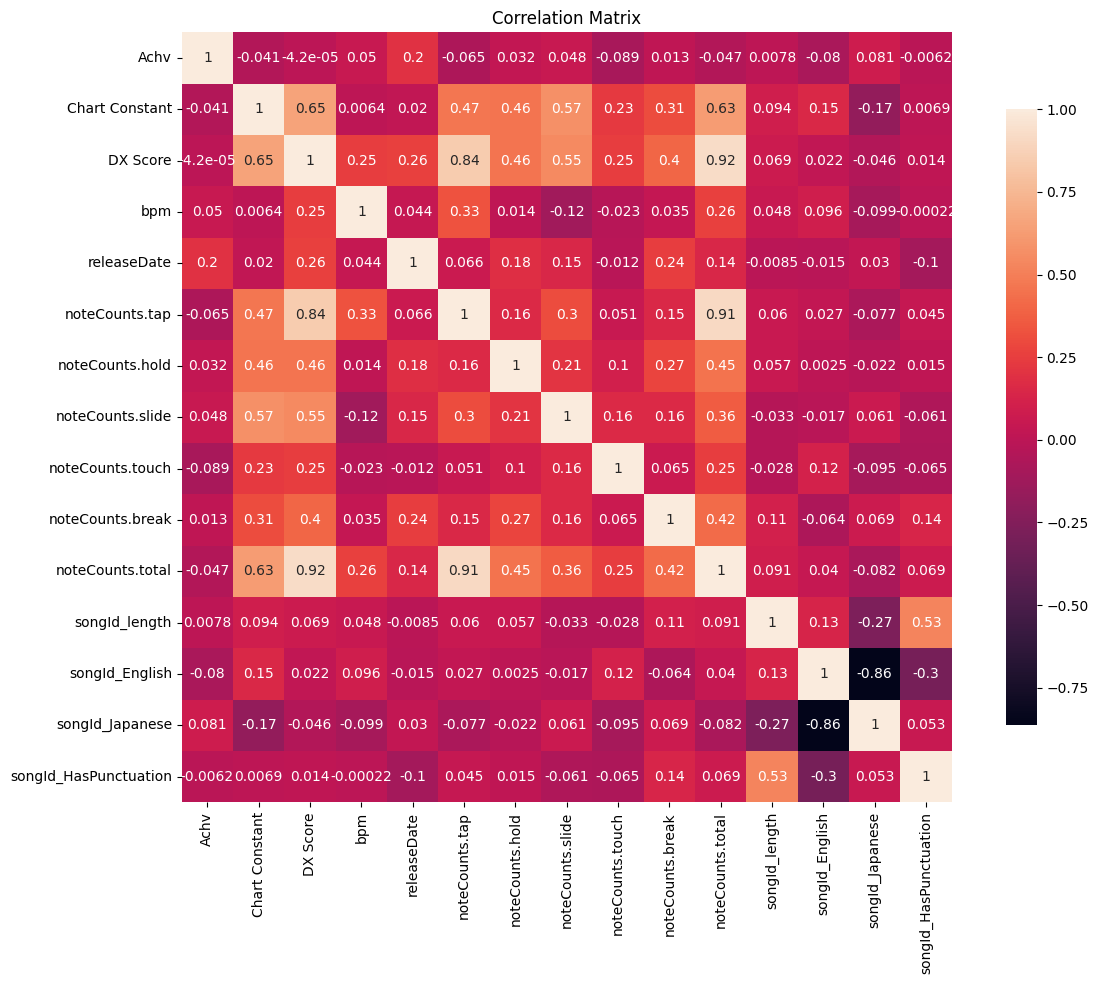

In [21]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

# Filter out numerical columns for correlation matrix
correlation_matrix = merged_df.select_dtypes(include=['number']).corr()

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title('Correlation Matrix')
plt.show()

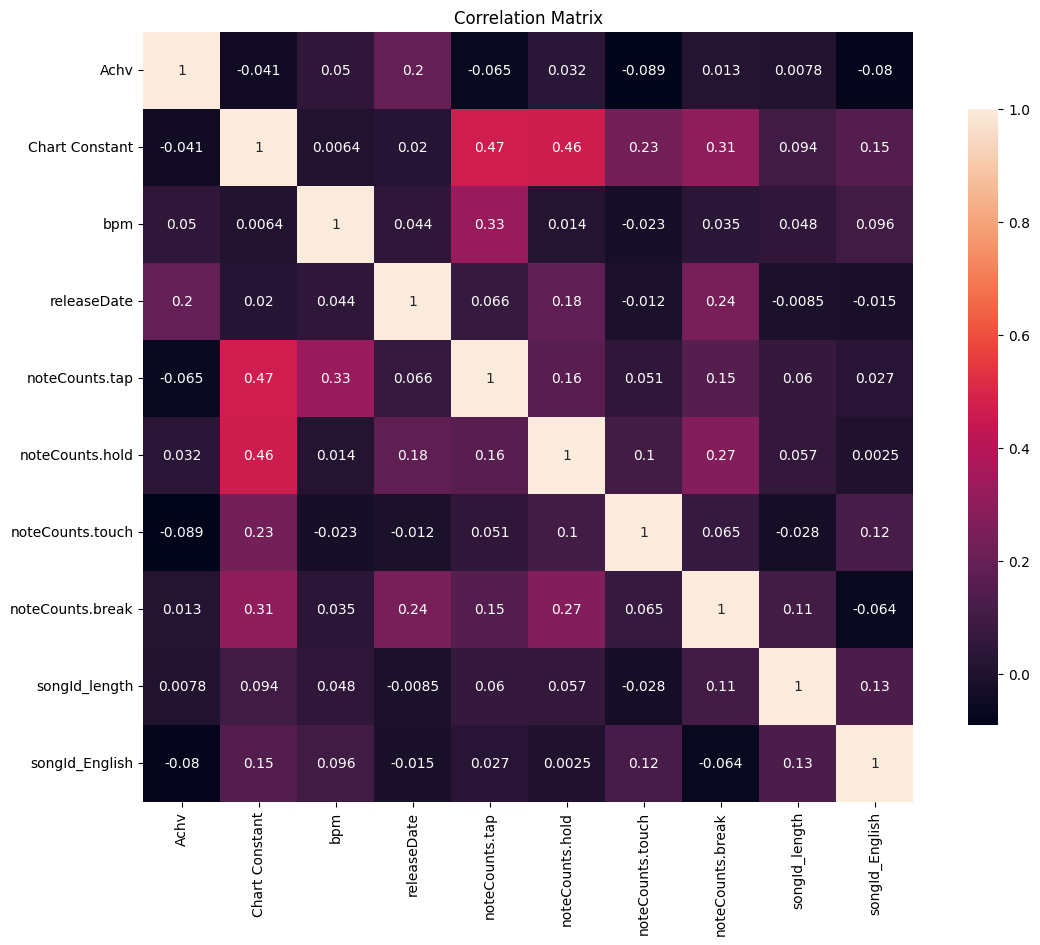

In [22]:
# Drop collinear columns
merged_df.drop(columns=["noteCounts.total", "noteCounts.slide", "DX Score", "songId_Japanese", "songId_HasPunctuation"], inplace=True)

correlation_matrix = merged_df.select_dtypes(include=['number']).corr()

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title('Correlation Matrix')
plt.show()

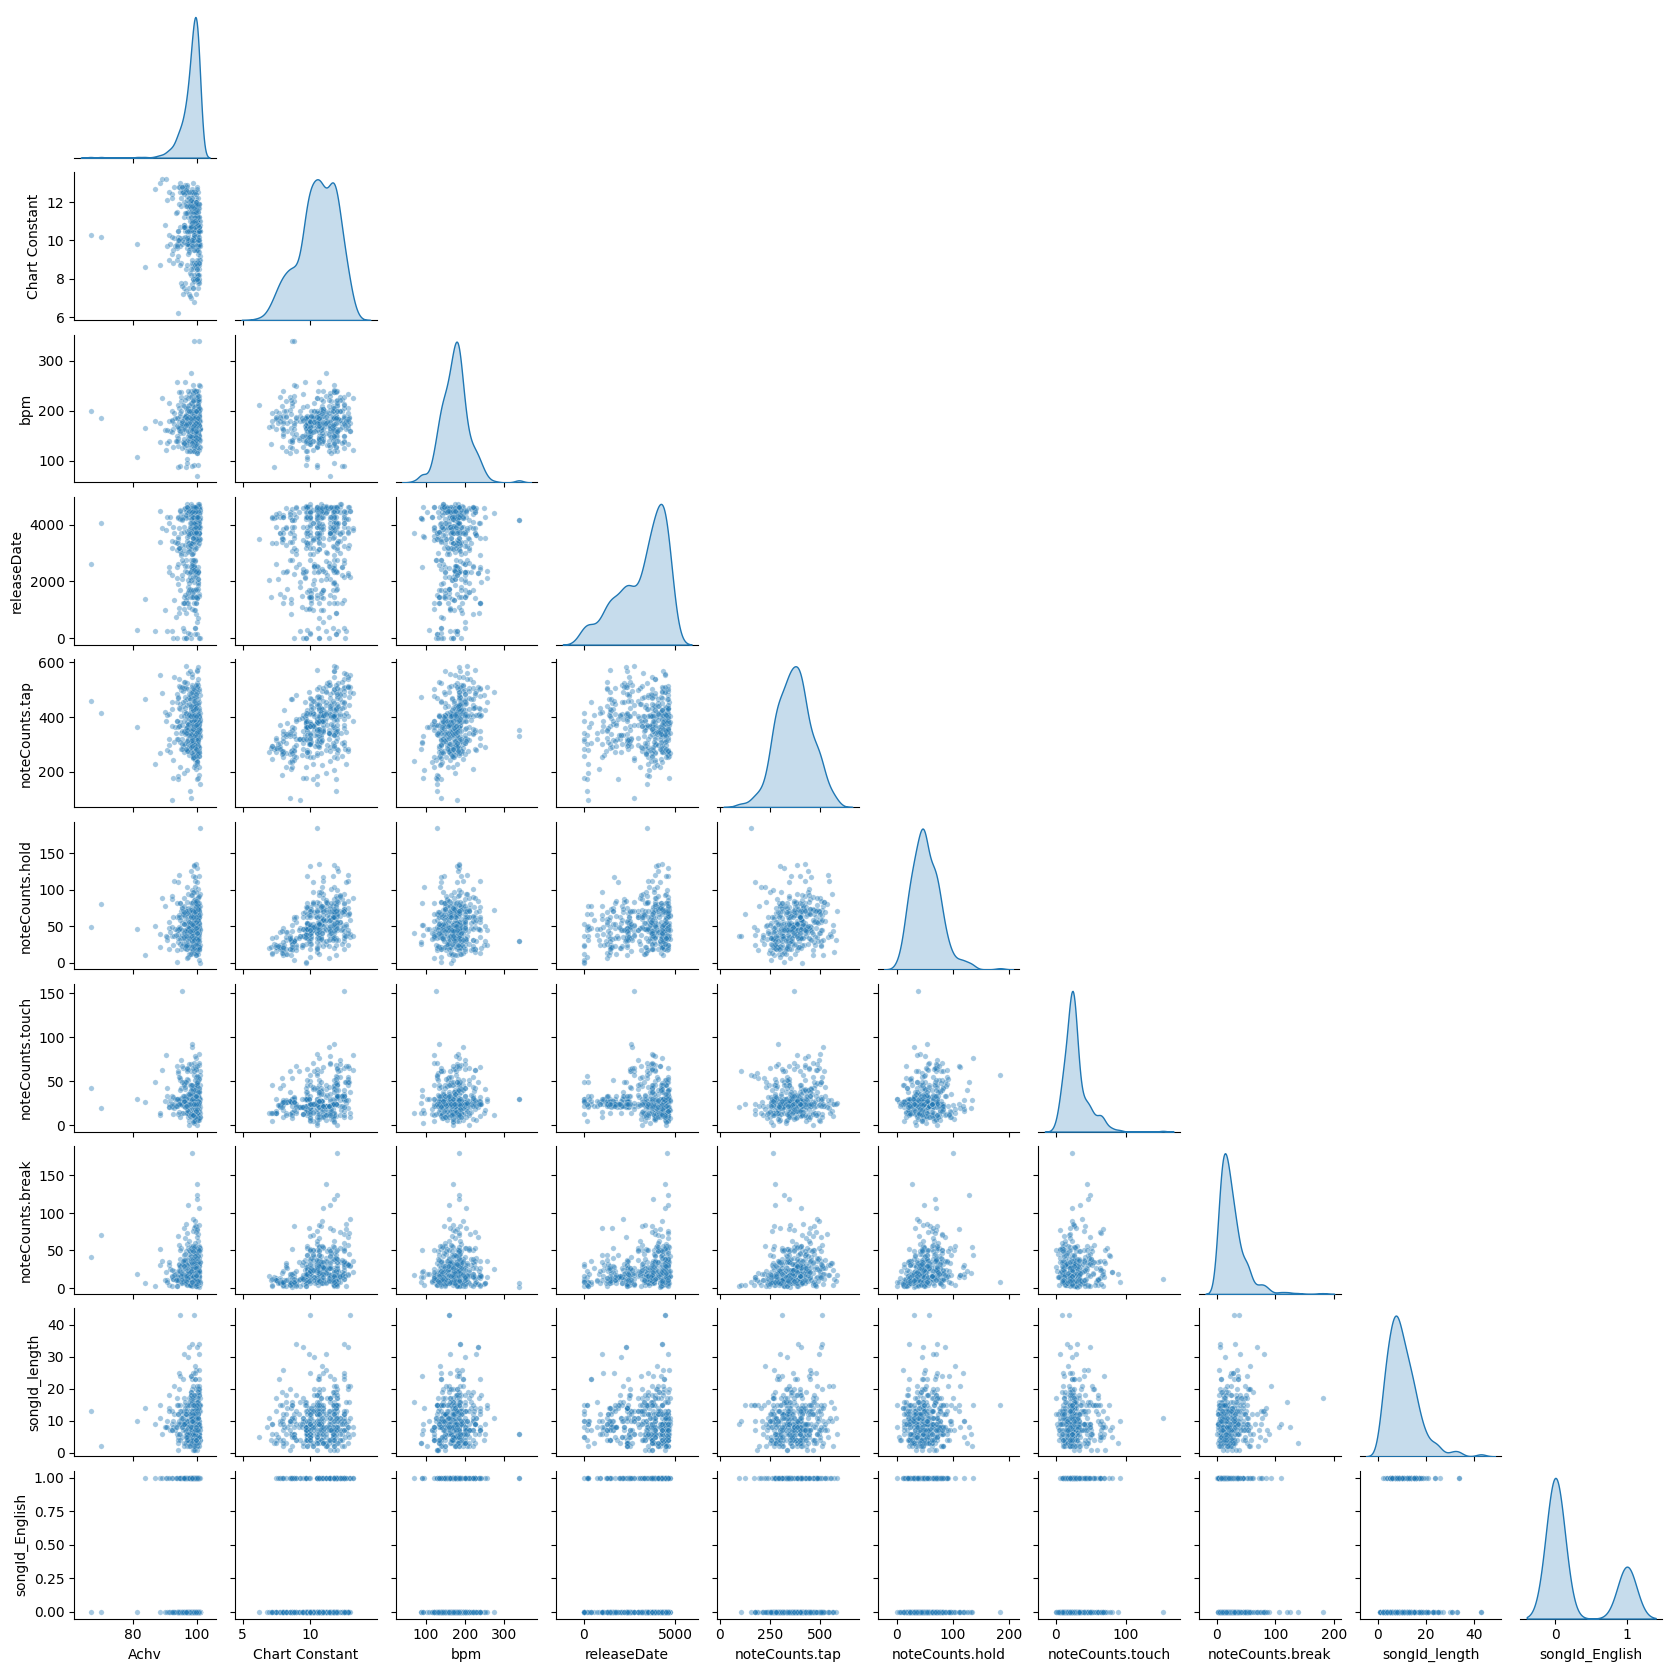

In [23]:
# Pairwise correlation with seaborn
sns.pairplot(merged_df,
    diag_kind="kde",
    plot_kws={'alpha': 0.4, 's': 15},
    corner=True,
    height=1.7,
)
plt.show()

3D Visualization

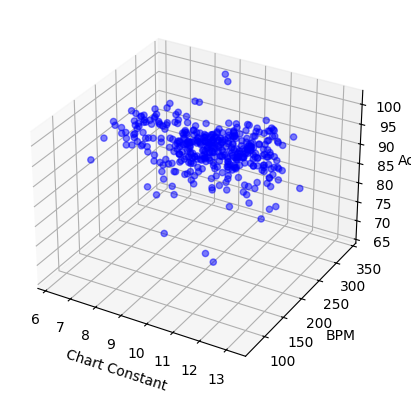

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    merged_df["Chart Constant"],
    merged_df["bpm"],
    merged_df["Achv"],
    c='b',
    marker='o',
    alpha=0.5
)
ax.set_xlabel('Chart Constant')
ax.set_ylabel('BPM')
ax.set_zlabel('Achv')
plt.show()

Regression

In [25]:
print(merged_df.columns)
# NaN features
print("Dropping ", merged_df.isna().any(axis=1).sum(), "NaN features")
merged_df.dropna(inplace=True)

Index(['songId', 'Genre', 'Version', 'type', 'difficulty', 'Level', 'Achv',
       'Rank', 'Chart Constant', 'bpm', 'releaseDate', 'noteCounts.tap',
       'noteCounts.hold', 'noteCounts.touch', 'noteCounts.break',
       'noteDesigner', 'songId_length', 'songId_English'],
      dtype='object')
Dropping  44 NaN features


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_features = merged_df.select_dtypes(include=['number']).columns.drop('Achv').tolist()
categorical_features = ['Genre', 'type', 'difficulty'] # 'Version'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('poly_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown="error",
                              categories=[merged_df[column].unique().tolist() for column in categorical_features]
            ), categorical_features)
    ]
)
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', RFE(LinearRegression(), n_features_to_select=10, step=1)),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    merged_df[numerical_features + categorical_features],
    merged_df['Achv'],
    random_state=42,
    test_size=0.2,
    stratify=merged_df["Rank"]
)

print("Training the model and performing automatic feature selection...")
pipeline_poly.fit(X_train, y_train)
print("Training complete.")

y_train_pred = pipeline_poly.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_absolute_error(y_train, y_train_pred)
print("Train set performance:")
print(f"R^2 Score: {train_r2:.4f}")
print(f"Mean Absolute Error: {train_mse:.4f}")

y_test_pred = pipeline_poly.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_absolute_error(y_test, y_test_pred)
print("Test set performance:")
print(f"R^2 Score: {test_r2:.4f}")
print(f"Mean Absolute Error: {test_mse:.4f}")

poly_features_step = pipeline_poly.named_steps['preprocessor'].named_transformers_['num'].named_steps['poly_features']
poly_feature_names = poly_features_step.get_feature_names_out(numerical_features)
cat_encoder = pipeline_poly.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = list(poly_feature_names) + list(cat_feature_names)

selector_step = pipeline_poly.named_steps['feature_selector']
selected_mask = selector_step.support_

regressor_step = pipeline_poly.named_steps['regressor']

results_df = pd.DataFrame({
    'Feature': [all_feature_names[i] for i in range(len(all_feature_names)) if selected_mask[i]],
    'Coefficient': regressor_step.coef_
}).sort_values(by='Coefficient', ascending=False)
print(results_df)

Training the model and performing automatic feature selection...
Training complete.
Train set performance:
R^2 Score: 0.0796
Mean Absolute Error: 2.1033
Test set performance:
R^2 Score: -0.2644
Mean Absolute Error: 2.1839
                           Feature  Coefficient
5    Chart Constant noteCounts.tap     9.946343
6  Chart Constant noteCounts.break     6.427768
0                   Chart Constant     6.375660
2                  noteCounts.hold     0.507094
7              bpm noteCounts.hold    -0.425299
9  noteCounts.tap noteCounts.break    -2.207637
1                   noteCounts.tap    -2.766861
3                 noteCounts.break    -4.289545
8                 noteCounts.tap^2    -4.571336
4                 Chart Constant^2   -10.873761


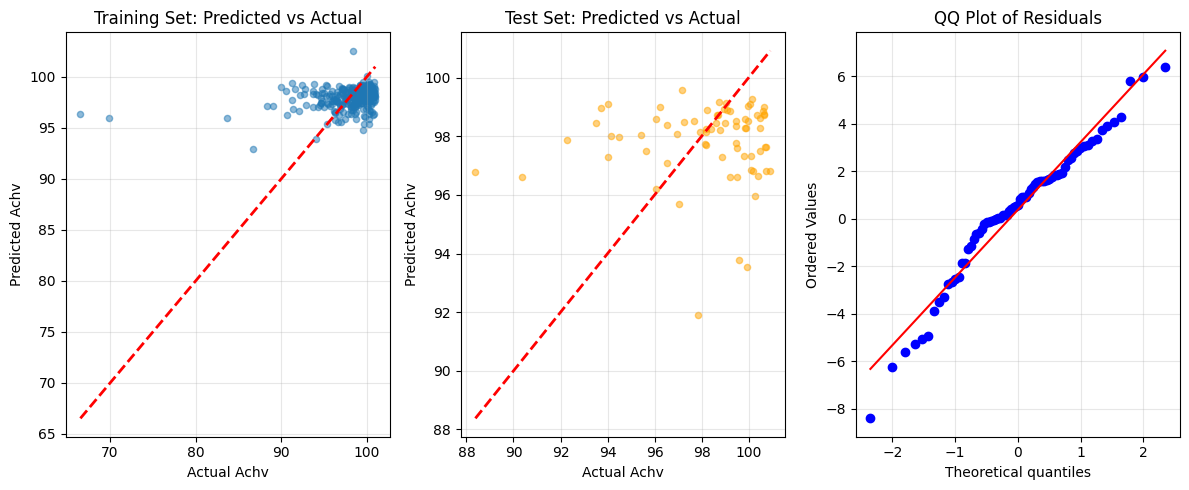

In [27]:
from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Achv')
axes[0].set_ylabel('Predicted Achv')
axes[0].set_title('Training Set: Predicted vs Actual')
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Achv')
axes[1].set_ylabel('Predicted Achv')
axes[1].set_title('Test Set: Predicted vs Actual')
axes[1].grid(True, alpha=0.3)

# 3. Residual QQ plot
residuals = y_test - y_test_pred
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot of Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown="error",
                              categories=[merged_df[column].unique().tolist() for column in categorical_features]
            ), categorical_features)
    ]
)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('rfr', RandomForestRegressor(
        random_state=42,
    ))
])
param_grid = {
    'rfr__n_estimators': [50, 100, 150],
    'rfr__max_depth': np.arange(2, 7, 2),
    'rfr__min_samples_split': [5, 10],
    'rfr__min_samples_leaf': [2, 5],
    'rfr__ccp_alpha': [0, 0.05, 0.1],
}
grid_search = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=8,
    verbose=10,
)

grid_search.fit(X_train, y_train)
pipeline_rf = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.4f}")

y_train_pred_rf = pipeline_rf.predict(X_train)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mse_rf = mean_absolute_error(y_train, y_train_pred_rf)
print("Train set performance:")
print(f"R^2 Score: {train_r2_rf:.4f}")
print(f"Mean Absolute Error: {train_mse_rf:.4f}")

y_test_pred_rf = pipeline_rf.predict(X_test)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mse_rf = mean_absolute_error(y_test, y_test_pred_rf)
print("Test set performance:")
print(f"R^2 Score: {test_r2_rf:.4f}")
print(f"Mean Absolute Error: {test_mse_rf:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'rfr__ccp_alpha': 0.05, 'rfr__max_depth': np.int64(2), 'rfr__min_samples_leaf': 5, 'rfr__min_samples_split': 5, 'rfr__n_estimators': 150}
Best CV MAE: 2.1119
Train set performance:
R^2 Score: 0.1779
Mean Absolute Error: 1.9505
Test set performance:
R^2 Score: 0.1074
Mean Absolute Error: 1.8656


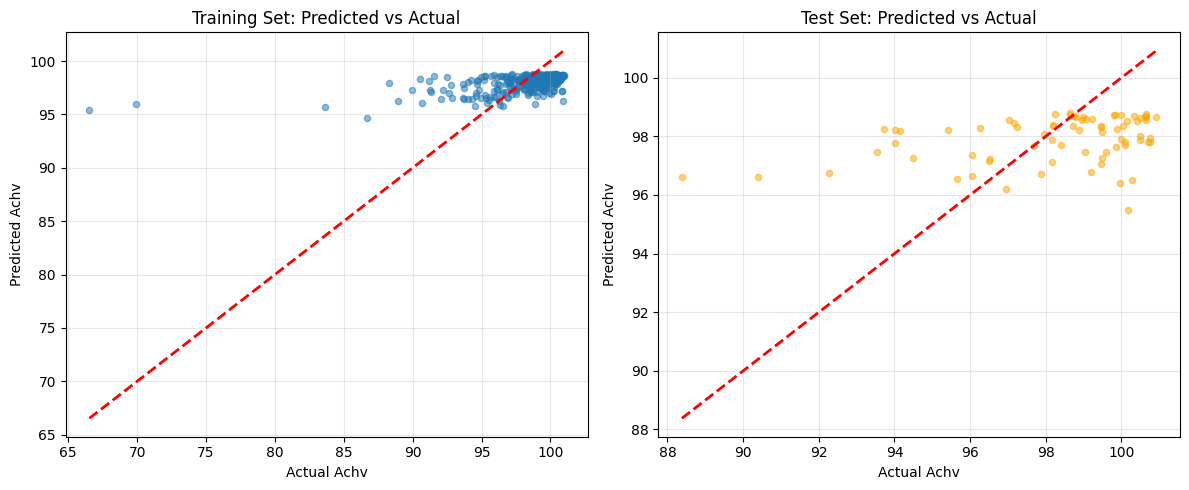

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train, y_train_pred_rf, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Achv')
axes[0].set_ylabel('Predicted Achv')
axes[0].set_title('Training Set: Predicted vs Actual')
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Achv')
axes[1].set_ylabel('Predicted Achv')
axes[1].set_title('Test Set: Predicted vs Actual')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

                     Feature  Importance
0             Chart Constant    0.328518
2                releaseDate    0.219608
3             noteCounts.tap    0.166756
6           noteCounts.break    0.117673
7              songId_length    0.056447
5           noteCounts.touch    0.044893
4            noteCounts.hold    0.030079
8             songId_English    0.020387
10  Genre_niconico＆VOCALOID™    0.009104
1                        bpm    0.006534


C:\Users\123er\AppData\Local\Temp\ipykernel_7728\243275759.py:24: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Personal Data\Repositories\personal-repo\test\toy\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


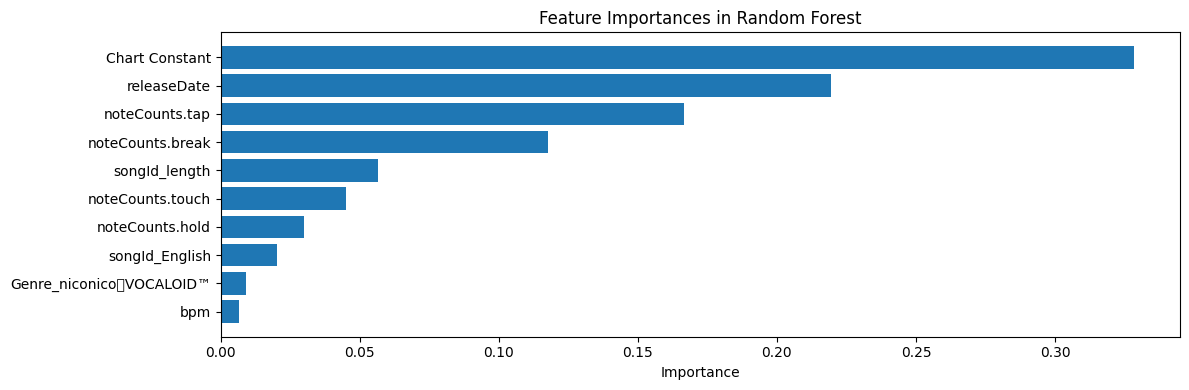

In [30]:
rf_features_step = pipeline_rf.named_steps['preprocessor'].named_transformers_['num']
rf_numeric_feature_names = rf_features_step.get_feature_names_out(numerical_features)

cat_encoder_rf = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names_rf = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names_rf = list(rf_numeric_feature_names) + list(cat_feature_names_rf)
rf_model = pipeline_rf.named_steps['rfr']

importance_df = pd.DataFrame({
    'Feature': all_feature_names_rf,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(importance_df[importance_df['Importance'] > 0])

fig, ax = plt.subplots(figsize=(12, 4))
top_features = importance_df[importance_df['Importance'] > 0]
ax.barh(range(len(top_features)), top_features['Importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance')
ax.set_title('Feature Importances in Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [31]:
from sklearn.linear_model import Ridge

pipeline_poly10 = Pipeline(steps=[
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('feature_selector', RFE(Ridge(alpha=1.0), n_features_to_select=10, step=1)),
    ('regressor', Ridge(alpha=1.0))
])
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    merged_df[['Chart Constant', 'bpm', 'releaseDate']],
    merged_df['Achv'],
    random_state=42,
    test_size=0.2,
    stratify=merged_df["Rank"]
)

pipeline_poly10.fit(X_train_simple, y_train_simple)

poly_step = pipeline_poly10.named_steps['poly_features']
feature_names = poly_step.get_feature_names_out(['Chart Constant', 'bpm', 'releaseDate'])
selector = pipeline_poly10.named_steps['feature_selector']
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.support_[i]]
coefficients = pipeline_poly10.named_steps['regressor'].coef_
print("\nSelected Features and Coefficients:")
for feature, coef in zip(selected_features, coefficients):
    print(f"{feature:40s}: {coef:10.6f}")


Selected Features and Coefficients:
Chart Constant                          :  -2.739041
Chart Constant^4                        :   1.821943
Chart Constant^5                        :   2.196629
Chart Constant^6                        :   2.001288
Chart Constant^5 releaseDate            :   1.312361
bpm^3 releaseDate^3                     :   0.214943
Chart Constant^6 releaseDate            :   0.807839
Chart Constant^9                        :  -1.383472
Chart Constant^10                       :  -3.190941
Chart Constant^8 releaseDate^2          :  -1.253862


In [32]:
y_train_pred_poly10 = pipeline_poly10.predict(X_train_simple)
train_r2_poly10 = r2_score(y_train_simple, y_train_pred_poly10)
train_mae_poly10 = mean_absolute_error(y_train_simple, y_train_pred_poly10)
print("\nTrain set performance:")
print(f"R^2 Score: {train_r2_poly10:.4f}")
print(f"Mean Absolute Error: {train_mae_poly10:.4f}")

y_test_pred_poly10 = pipeline_poly10.predict(X_test_simple)
test_r2_poly10 = r2_score(y_test_simple, y_test_pred_poly10)
test_mae_poly10 = mean_absolute_error(y_test_simple, y_test_pred_poly10)
print("\nTest set performance:")
print(f"R^2 Score: {test_r2_poly10:.4f}")
print(f"Mean Absolute Error: {test_mae_poly10:.4f}")


Train set performance:
R^2 Score: 0.0854
Mean Absolute Error: 1.9951

Test set performance:
R^2 Score: 0.2830
Mean Absolute Error: 1.7351


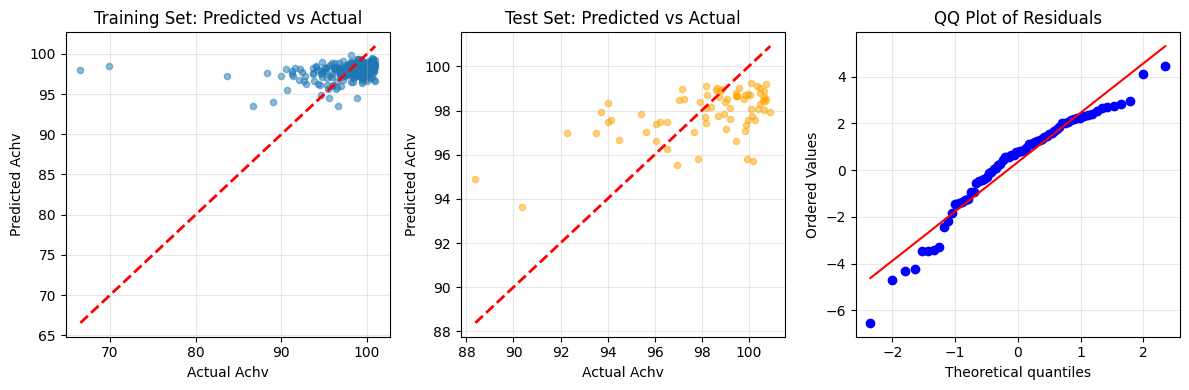

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(y_train_simple, y_train_pred_poly10, alpha=0.5, s=20)
axes[0].plot([y_train_simple.min(), y_train_simple.max()], 
             [y_train_simple.min(), y_train_simple.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Achv')
axes[0].set_ylabel('Predicted Achv')
axes[0].set_title('Training Set: Predicted vs Actual')
axes[0].grid(True, alpha=0.3)
axes[1].scatter(y_test_simple, y_test_pred_poly10, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test_simple.min(), y_test_simple.max()], 
             [y_test_simple.min(), y_test_simple.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Achv')
axes[1].set_ylabel('Predicted Achv')
axes[1].set_title('Test Set: Predicted vs Actual')
axes[1].grid(True, alpha=0.3)
residuals_poly10 = y_test_simple - y_test_pred_poly10
stats.probplot(residuals_poly10, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot of Residuals')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()